In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch import nn,optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
train_path = "./drive/MyDrive/data/train"
val_path = "./drive/MyDrive/data/val"

train_data = ImageFolder(train_path)
val_data = ImageFolder(val_path)

classes=train_data.classes
print("Classes",classes)

Classes ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [5]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [6]:
train_data=ImageFolder(train_path,transform=transform)
val_data=ImageFolder(val_path,transform=transform)

train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32)

len(train_loader),len(val_loader)

(45, 12)

In [7]:
model=models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.fc=nn.Linear(model.fc.in_features,len(classes))
model=model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [8]:
epochs=6
train_losses=[]
val_losses=[]

for epoch in range(epochs):
    model.train()
    running_loss=0

    for imgs,labels in train_loader:
      imgs,labels=imgs.to(device),labels.to(device)
      optimizer.zero_grad()
      output=model(imgs)
      loss=criterion(output,labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()

    train_losses.append(running_loss/len(train_loader))
    model.eval()
    val_loss=0
    with torch.no_grad():
      for imgs,labels in val_loader:
        imgs,labels=imgs.to(device),labels.to(device)
        output=model(imgs)
        loss=criterion(output,labels)
        val_loss+=loss.item()
    val_losses.append(val_loss/len(val_loader))
    print(f"Epoch {epoch+1}/{epochs}.. Training Loss: {train_losses[-1]:.4f}.. Validation Loss: {val_losses[-1]:.4f}")

Epoch 1/6.. Training Loss: 1.1801.. Validation Loss: 0.9519
Epoch 2/6.. Training Loss: 0.5334.. Validation Loss: 0.4356
Epoch 3/6.. Training Loss: 0.3434.. Validation Loss: 0.3434
Epoch 4/6.. Training Loss: 0.2734.. Validation Loss: 0.2431
Epoch 5/6.. Training Loss: 0.2212.. Validation Loss: 0.2242
Epoch 6/6.. Training Loss: 0.1875.. Validation Loss: 0.1929


In [9]:
os.makedirs("./backend/model",exist_ok=True)
torch.save(model.state_dict(),"./backend/model/defect_classifier.pth")
print("Model Saved")

Model Saved


In [10]:
model.eval()
preds=[]
actual=[]

with torch.no_grad():
  for imgs,labels in val_loader:
    imgs=imgs.to(device)
    outputs=model(imgs)
    _,predicted=torch.max(outputs,1)
    preds.extend(predicted.cpu().numpy())
    actual.extend(labels.numpy())
print(classification_report(actual,preds,target_names=classes))

                 precision    recall  f1-score   support

        crazing       0.94      1.00      0.97        60
      inclusion       0.98      0.93      0.96        60
        patches       1.00      0.95      0.97        60
 pitted_surface       0.94      0.98      0.96        60
rolled-in_scale       1.00      0.98      0.99        60
      scratches       1.00      1.00      1.00        60

       accuracy                           0.97       360
      macro avg       0.98      0.97      0.98       360
   weighted avg       0.98      0.97      0.98       360



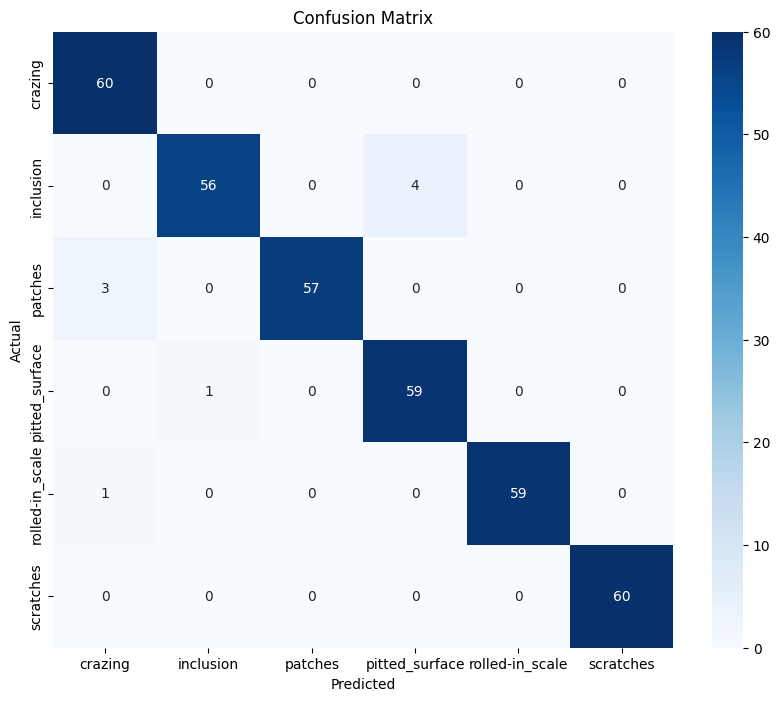

In [11]:
cm=confusion_matrix(actual,preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=classes,yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()